## Problem Statement

Predict the forest cover type from the given cartographic variables. This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from scipy.stats import norm 
from matplotlib import cm
import seaborn as sns

In [2]:
import os
print(os.listdir("/kaggle/input/forest-cover-type-kernels-only"))

['train.csv.zip', 'sampleSubmission.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']


In [3]:
import zipfile
train_zip = zipfile.ZipFile('/kaggle/input/forest-cover-type-kernels-only/train.csv.zip')
test_zip = zipfile.ZipFile('/kaggle/input/forest-cover-type-kernels-only/test.csv.zip')

train = pd.read_csv(train_zip.open('train.csv'))
test = pd.read_csv(test_zip.open('test.csv'))

Id = test['Id']

Data Exploration and analysis

In [4]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [5]:
test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,...,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,...,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,...,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,...,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

The given dataset cantains 56 features including the target variable Cover_Type, along with 15120 observations and following are the features

* Elevation - Elevation in meters
* Aspect - Aspect in degrees azimuth
* Slope - Slope in degrees
* Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
* Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
* Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
* Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
* Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
* Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
* Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
* Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
* Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
* Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

The wilderness areas are:

* 1 - Rawah Wilderness Area
* 2 - Neota Wilderness Area
* 3 - Comanche Peak Wilderness Area
* 4 - Cache la Poudre Wilderness Area

The soil types are:

* 1 Cathedral family - Rock outcrop complex, extremely stony.
* 2 Vanet - Ratake families complex, very stony.
* 3 Haploborolis - Rock outcrop complex, rubbly.
* 4 Ratake family - Rock outcrop complex, rubbly.
* 5 Vanet family - Rock outcrop complex complex, rubbly.
* 6 Vanet - Wetmore families - Rock outcrop complex, stony.
* 7 Gothic family.
* 8 Supervisor - Limber families complex.
* 9 Troutville family, very stony.
* 10 Bullwark - Catamount families - Rock outcrop complex, rubbly.
* 11 Bullwark - Catamount families - Rock land complex, rubbly.
* 12 Legault family - Rock land complex, stony.
* 13 Catamount family - Rock land - Bullwark family complex, rubbly.
* 14 Pachic Argiborolis - Aquolis complex.
* 15 unspecified in the USFS Soil and ELU Survey.
* 16 Cryaquolis - Cryoborolis complex.
* 17 Gateview family - Cryaquolis complex.
* 18 Rogert family, very stony.
* 19 Typic Cryaquolis - Borohemists complex.
* 20 Typic Cryaquepts - Typic Cryaquolls complex.
* 21 Typic Cryaquolls - Leighcan family, till substratum complex.
* 22 Leighcan family, till substratum, extremely bouldery.
* 23 Leighcan family, till substratum - Typic Cryaquolls complex.
* 24 Leighcan family, extremely stony.
* 25 Leighcan family, warm, extremely stony.
* 26 Granile - Catamount families complex, very stony.
* 27 Leighcan family, warm - Rock outcrop complex, extremely stony.
* 28 Leighcan family - Rock outcrop complex, extremely stony.
* 29 Como - Legault families complex, extremely stony.
* 30 Como family - Rock land - Legault family complex, extremely stony.
* 31 Leighcan - Catamount families complex, extremely stony.
* 32 Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
* 33 Leighcan - Catamount families - Rock outcrop complex, extremely stony.
* 34 Cryorthents - Rock land complex, extremely stony.
* 35 Cryumbrepts - Rock outcrop - Cryaquepts complex.
* 36 Bross family - Rock land - Cryumbrepts complex, extremely stony.
* 37 Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
* 38 Leighcan - Moran families - Cryaquolls complex, extremely stony.
* 39 Moran family - Cryorthents - Leighcan family complex, extremely stony.
* 40 Moran family - Cryorthents - Rock land complex, extremely stony.

In [7]:
print("The number of traning examples(data points) = %i " % train.shape[0])
print("The number of features we have = %i " % train.shape[1])

The number of traning examples(data points) = 15120 
The number of features we have = 56 


In [8]:
print("The number of traning examples(data points) = %i " % test.shape[0])
print("The number of features we have = %i " % test.shape[1])

The number of traning examples(data points) = 565892 
The number of features we have = 55 


Let's check if any of the columns contains NaNs or Nulls so that we can fill those values if they are insignificant or drop them. We may drop a whole column if most of its values are NaNs or fill its value according to its relation with other columns in the dataframe. Nones can also be 0 in some datasets and that is why i am going to use the describe of the train to see if the range of numbers is not reasonable or not. if you are dropping rows with NaNs and you notice that you need to drop a large portion of your dataset then you should think about filling the NaN values or drop a column that has most of its values missing.

In [9]:
train.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [10]:
train.isnull().sum()

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


It seems we don't have any NaN or Null value among the dataset we are trying to classify. Let's now discover the correlation matrix for this dataset and see if we can combine features or drop some according to its correlation with the output labels.

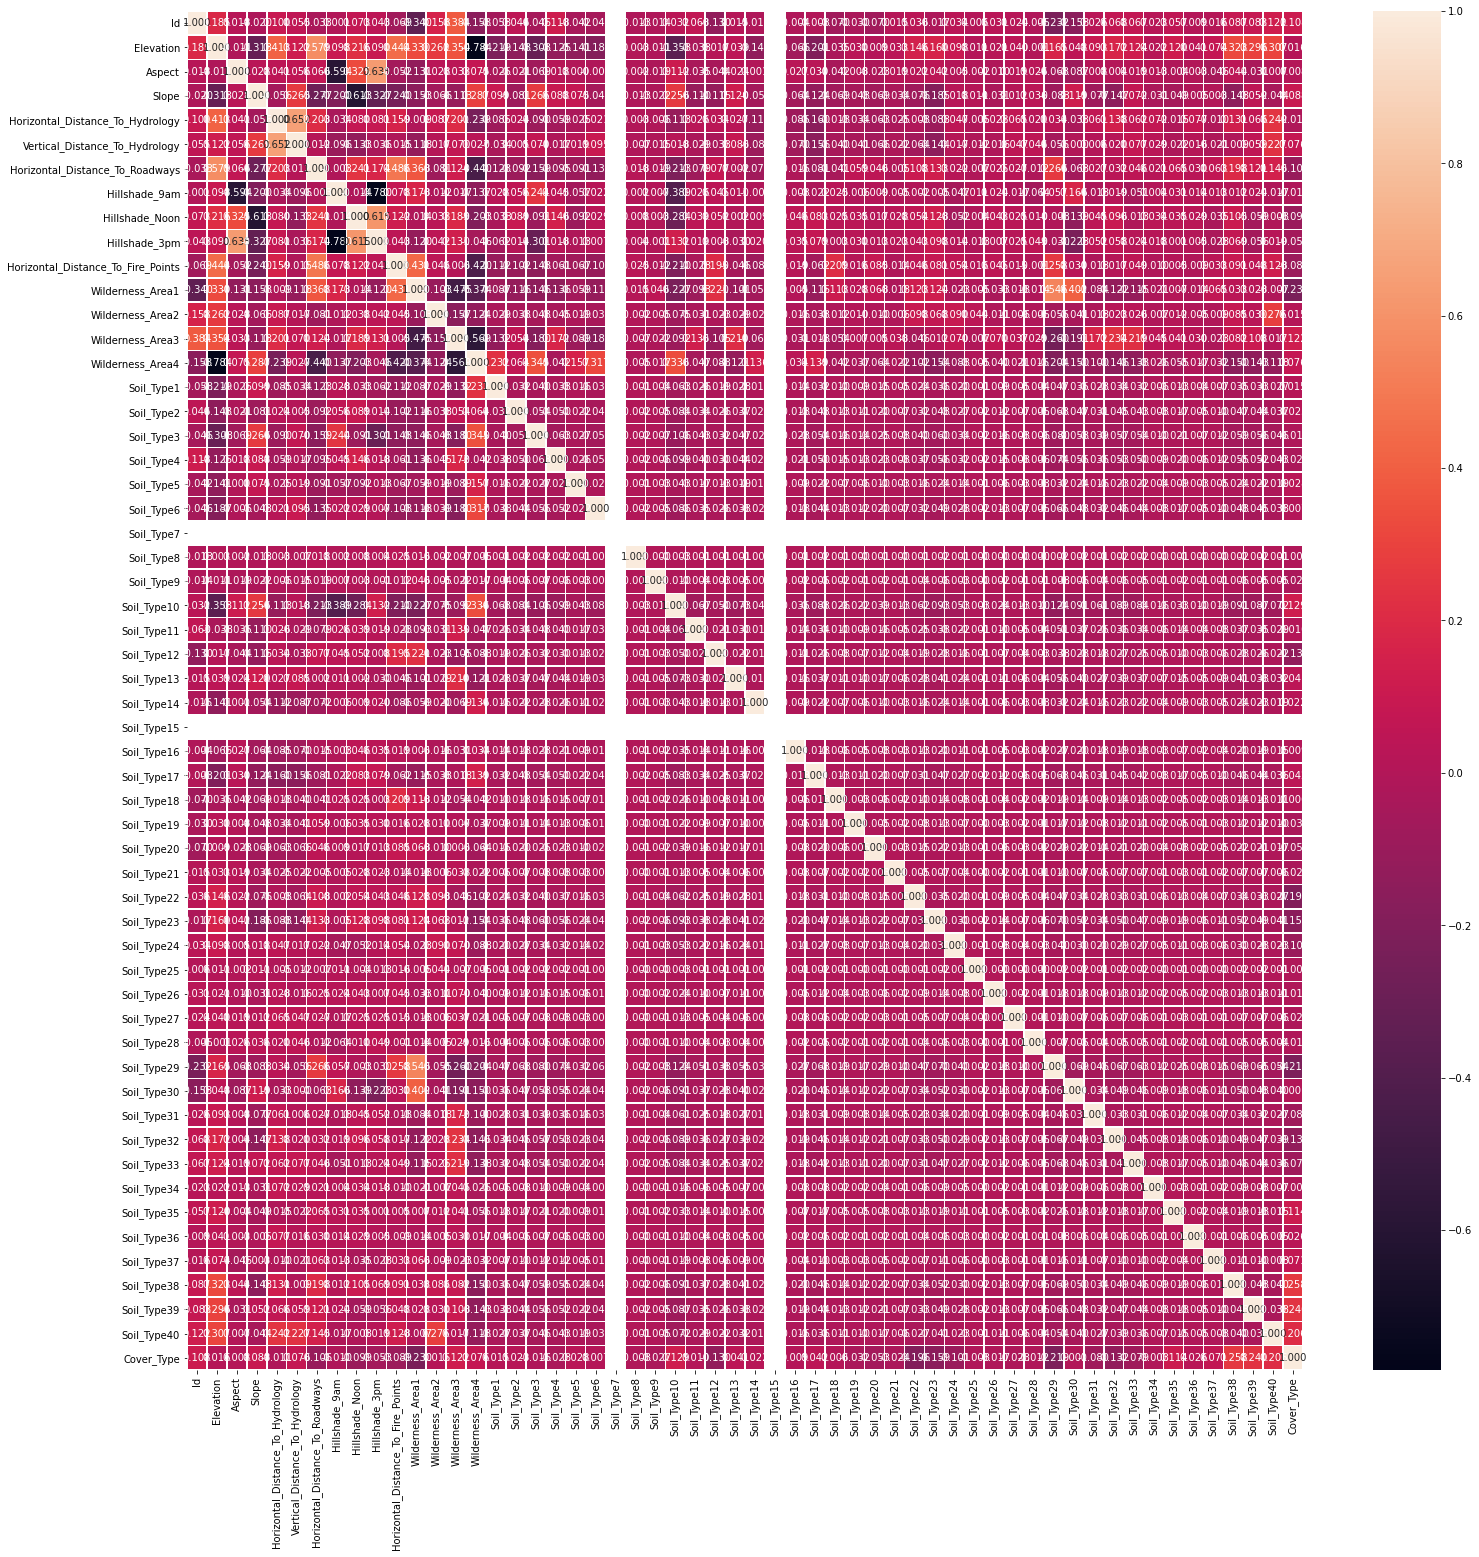

In [11]:
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax)
plt.show()

In [12]:
train.corr()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,1.000000,0.185496,0.017702,-0.020168,0.099637,0.055348,-0.033028,0.000786,0.073123,0.042524,...,0.068048,0.066887,0.022520,0.057480,0.009110,0.016040,0.086932,0.083376,0.122475,0.108363
Elevation,0.185496,1.000000,-0.011096,-0.312640,0.412712,0.122092,0.578659,0.097900,0.215782,0.089518,...,0.172349,0.123821,0.021876,0.120157,0.040571,0.073825,0.323440,0.296405,0.306755,0.016090
Aspect,0.017702,-0.011096,1.000000,0.028148,0.040732,0.056412,0.066184,-0.593997,0.324912,0.635022,...,0.003700,0.018719,0.012927,-0.004235,0.003160,-0.046309,0.043860,-0.031342,0.007208,0.008015
Slope,-0.020168,-0.312640,0.028148,1.000000,-0.055976,0.265314,-0.277049,-0.200072,-0.612613,-0.326887,...,-0.147258,0.072027,-0.030590,-0.048855,-0.004570,0.003129,-0.148342,0.051900,-0.043513,0.087722
Horizontal_Distance_To_Hydrology,0.099637,0.412712,0.040732,-0.055976,1.000000,0.652142,0.203397,-0.033803,0.080047,0.080833,...,0.138275,0.062121,0.072485,-0.015446,0.077251,-0.009549,0.131444,0.066284,0.242304,-0.010515
Vertical_Distance_To_Hydrology,0.055348,0.122092,0.056412,0.265314,0.652142,1.000000,0.011555,-0.095930,-0.132948,-0.035559,...,0.020298,0.077167,0.028910,-0.021662,0.015680,-0.020717,-0.008989,0.058981,0.227110,0.075647
Horizontal_Distance_To_Roadways,-0.033028,0.578659,0.066184,-0.277049,0.203397,0.011555,1.000000,-0.003398,0.240684,0.173882,...,0.031538,0.045797,0.021415,0.065310,0.030282,0.063302,0.197892,0.120953,0.144786,-0.105662
Hillshade_9am,0.000786,0.097900,-0.593997,-0.200072,-0.033803,-0.095930,-0.003398,1.000000,-0.013712,-0.779965,...,0.018760,-0.050739,0.004457,0.031228,0.013886,0.013207,0.012326,0.024492,-0.017234,-0.010286
Hillshade_Noon,0.073123,0.215782,0.324912,-0.612613,0.080047,-0.132948,0.240684,-0.013712,1.000000,0.614526,...,0.096261,-0.013129,0.034149,0.034638,0.029261,-0.035385,0.104682,-0.058979,-0.008203,-0.098905
Hillshade_3pm,0.042524,0.089518,0.635022,-0.326887,0.080833,-0.035559,0.173882,-0.779965,0.614526,1.000000,...,0.058244,0.024496,0.018298,0.000662,0.004545,-0.028055,0.069262,-0.056383,0.019158,-0.053399


From the above results it seems that soil_Type7 and soil_Type15 doesn't haveany correlation with the output cover_Type so we can easily drop them from the data we have. Also Soil_Type9, Soil_Type36, Soil_Type27, Soil_Type25, Soil_Type8 have weak correlation, but when a feature has a weak correlation tht doesn't mean it is useful cuz combined with other feature it may make a good impact. I choose those columns after experimenting many times with the data i have from the Extratrees, correlation matrix and the heatmap.

In [13]:
#train.drop(['Id'], inplace = True, axis = 1 )
train.drop(['Id','Soil_Type15' , "Soil_Type7"], inplace = True, axis = 1 )
test.drop(['Id','Soil_Type15' , "Soil_Type7"], inplace = True, axis = 1 )

In [14]:
train['HorizontalHydrology_HorizontalFire'] = (train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points'])
train['Neg_HorizontalHydrology_HorizontalFire'] = (train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
train['HorizontalHydrology_HorizontalRoadways'] = (train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
train['Neg_HorizontalHydrology_HorizontalRoadways'] = (train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
train['HorizontalFire_Points_HorizontalRoadways'] = (train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
train['Neg_HorizontalFire_Points_HorizontalRoadways'] = (train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])

train['Neg_Elevation_Vertical'] = train['Elevation']-train['Vertical_Distance_To_Hydrology']
train['Elevation_Vertical'] = train['Elevation']+train['Vertical_Distance_To_Hydrology']

train['mean_hillshade'] =  (train['Hillshade_9am']  + train['Hillshade_Noon'] + train['Hillshade_3pm'] ) / 3

train['Mean_HorizontalHydrology_HorizontalFire'] = (train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points'])/2
train['Mean_HorizontalHydrology_HorizontalRoadways'] = (train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])/2
train['Mean_HorizontalFire_Points_HorizontalRoadways'] = (train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])/2

train['MeanNeg_Mean_HorizontalHydrology_HorizontalFire'] = (train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])/2
train['MeanNeg_HorizontalHydrology_HorizontalRoadways'] = (train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])/2
train['MeanNeg_HorizontalFire_Points_HorizontalRoadways'] = (train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])/2

train['Slope2'] = np.sqrt(train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)
train['Mean_Fire_Hydrology_Roadways']=(train['Horizontal_Distance_To_Fire_Points'] + train['Horizontal_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Roadways']) / 3
train['Mean_Fire_Hyd']=(train['Horizontal_Distance_To_Fire_Points'] + train['Horizontal_Distance_To_Hydrology']) / 2 

train["Vertical_Distance_To_Hydrology"] = abs(train['Vertical_Distance_To_Hydrology'])

train['Neg_EHyd'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2


test['HorizontalHydrology_HorizontalFire'] = (test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points'])
test['Neg_HorizontalHydrology_HorizontalFire'] = (test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])
test['HorizontalHydrology_HorizontalRoadways'] = (test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])
test['Neg_HorizontalHydrology_HorizontalRoadways'] = (test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])
test['HorizontalFire_Points_HorizontalRoadways'] = (test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])
test['Neg_HorizontalFire_Points_HorizontalRoadways'] = (test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])

test['Neg_Elevation_Vertical'] = test['Elevation']-test['Vertical_Distance_To_Hydrology']
test['Elevation_Vertical'] = test['Elevation'] + test['Vertical_Distance_To_Hydrology']

test['mean_hillshade'] = (test['Hillshade_9am']  + test['Hillshade_Noon']  + test['Hillshade_3pm'] ) / 3

test['Mean_HorizontalHydrology_HorizontalFire'] = (test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points'])/2
test['Mean_HorizontalHydrology_HorizontalRoadways'] = (test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])/2
test['Mean_HorizontalFire_Points_HorizontalRoadways'] = (test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])/2

test['MeanNeg_Mean_HorizontalHydrology_HorizontalFire'] = (test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])/2
test['MeanNeg_HorizontalHydrology_HorizontalRoadways'] = (test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])/2
test['MeanNeg_HorizontalFire_Points_HorizontalRoadways'] = (test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])/2

test['Slope2'] = np.sqrt(test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)
test['Mean_Fire_Hydrology_Roadways']=(test['Horizontal_Distance_To_Fire_Points'] + test['Horizontal_Distance_To_Hydrology'] + test['Horizontal_Distance_To_Roadways']) / 3 
test['Mean_Fire_Hyd']=(test['Horizontal_Distance_To_Fire_Points'] + test['Horizontal_Distance_To_Hydrology']) / 2


test['Vertical_Distance_To_Hydrology'] = abs(test["Vertical_Distance_To_Hydrology"])

test['Neg_EHyd'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2

Now we should seperate the training set from the labels and name them x and y then we will split them into training and test sets to be able to see how well it would do on unseen data which will give anestimate on how well it will do when testing on Kaggle test data. I will use the convention of using 80% of the data as training set and 20% for the test set.

In [15]:
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Mean_HorizontalHydrology_HorizontalFire,Mean_HorizontalHydrology_HorizontalRoadways,Mean_HorizontalFire_Points_HorizontalRoadways,MeanNeg_Mean_HorizontalHydrology_HorizontalFire,MeanNeg_HorizontalHydrology_HorizontalRoadways,MeanNeg_HorizontalFire_Points_HorizontalRoadways,Slope2,Mean_Fire_Hydrology_Roadways,Mean_Fire_Hyd,Neg_EHyd
0,2596,51,3,258,0,510,221,232,148,6279,...,3268.5,384.0,3394.5,-3010.5,-126.0,2884.5,258.000000,2349.000000,3268.5,2544.4
1,2590,56,2,212,6,390,220,235,151,6225,...,3218.5,301.0,3307.5,-3006.5,-89.0,2917.5,212.084889,2275.666667,3218.5,2547.6
2,2804,139,9,268,65,3180,234,238,135,6121,...,3194.5,1724.0,4650.5,-2926.5,-1456.0,1470.5,275.769832,3189.666667,3194.5,2750.4
3,2785,155,18,242,118,3090,238,238,122,6211,...,3226.5,1666.0,4650.5,-2984.5,-1424.0,1560.5,269.235956,3181.000000,3226.5,2736.6
4,2595,45,2,153,1,391,220,234,150,6172,...,3162.5,272.0,3281.5,-3009.5,-119.0,2890.5,153.003268,2238.666667,3162.5,2564.4


In [16]:
test.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Mean_HorizontalHydrology_HorizontalFire,Mean_HorizontalHydrology_HorizontalRoadways,Mean_HorizontalFire_Points_HorizontalRoadways,MeanNeg_Mean_HorizontalHydrology_HorizontalFire,MeanNeg_HorizontalHydrology_HorizontalRoadways,MeanNeg_HorizontalFire_Points_HorizontalRoadways,Slope2,Mean_Fire_Hydrology_Roadways,Mean_Fire_Hyd,Neg_EHyd
0,2680,354,14,0,0,2684,196,214,156,6645,...,3322.5,1342.0,4664.5,-3322.5,-1342.0,1980.5,0.0,3109.666667,3322.5,2680.0
1,2683,0,13,0,0,2654,201,216,152,6675,...,3337.5,1327.0,4664.5,-3337.5,-1327.0,2010.5,0.0,3109.666667,3337.5,2683.0
2,2713,16,15,0,0,2980,206,208,137,6344,...,3172.0,1490.0,4662.0,-3172.0,-1490.0,1682.0,0.0,3108.000000,3172.0,2713.0
3,2709,24,17,0,0,2950,208,201,125,6374,...,3187.0,1475.0,4662.0,-3187.0,-1475.0,1712.0,0.0,3108.000000,3187.0,2709.0
4,2706,29,19,0,0,2920,210,195,115,6404,...,3202.0,1460.0,4662.0,-3202.0,-1460.0,1742.0,0.0,3108.000000,3202.0,2706.0


In [17]:
train.shape

(15120, 72)

In [18]:
test.shape

(565892, 71)

In [19]:
from sklearn.model_selection import train_test_split
x = train.drop(['Cover_Type'], axis = 1)
y = train['Cover_Type']


x_train, x_val, y_train, y_val = train_test_split( x.values, y.values, test_size=0.2, random_state=42 )
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(12096, 71)
(3024, 71)
(12096,)
(3024,)


It is important to know if the number of points in the classes are balanced. If the data is skewed then we will not be able to use accuracy as a performance metric since it will be misleading but if it is skewed we may use F-beta score or precision and recall. Precision or recall or F1 score. the choice depends on the problem itself. Where high recall means low number of false negatives , High precision means low number of false positives and F1 score is a trade off between them. You can refere to this article for more about precision and recall http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [20]:
unique, count= np.unique(y_train, return_counts=True)
print("The number of occurances of each class in the dataset = %s " % dict (zip(unique, count) ), "\n" )

The number of occurances of each class in the dataset = {1: 1739, 2: 1722, 3: 1732, 4: 1711, 5: 1744, 6: 1728, 7: 1720}  



It seems the data points in each class are almost balanced so it will be okay to use accuracy as a metric to measure how well the ML model performs

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

test = scaler.transform(test)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

## Select and Initialize Classifiers

I have tried to select various classifiers. The key is a good validation score and if possible the use of a diffferent method/classifier for the ensembling.

In [23]:
rf_1 = RandomForestClassifier(n_estimators = 200,criterion = 'entropy',random_state = 0)
rf_1.fit(X=x_train, y=y_train)

y_pred_train_rf_1 = rf_1.predict(x_train)
y_pred_val_rf_1 = rf_1.predict(x_val)

y_pred_test_rf_1 = rf_1.predict(test)

In [24]:
rf_2 = RandomForestClassifier(n_estimators = 200,criterion = 'gini',random_state = 0)
rf_2.fit(X=x_train, y=y_train)

y_pred_train_rf_2 = rf_2.predict(x_train)
y_pred_val_rf_2 = rf_2.predict(x_val)

y_pred_test_rf_2 = rf_2.predict(test)

In [25]:
et_1 = ExtraTreesClassifier(n_estimators = 200,criterion = 'entropy',random_state = 0)
et_1.fit(X=x_train, y=y_train)

y_pred_train_et_1 = et_1.predict(x_train)
y_pred_val_et_1 = et_1.predict(x_val)

y_pred_test_et_1 = et_1.predict(test)

In [26]:
et_2 = ExtraTreesClassifier(n_estimators = 200,criterion = 'gini',random_state = 0)
et_2.fit(X=x_train, y=y_train)

y_pred_train_et_2 = et_2.predict(x_train)
y_pred_val_et_2 = et_2.predict(x_val)

y_pred_test_et_2 = et_2.predict(test)

In [27]:
lgb = LGBMClassifier(n_estimators = 200,learning_rate = 0.1)
lgb.fit(X=x_train, y=y_train)

y_pred_train_lgb = lgb.predict(x_train)
y_pred_val_lgb = lgb.predict(x_val)

y_pred_test_lgb = lgb.predict(test)

In [28]:
lr_1 = LogisticRegression(solver = 'liblinear',multi_class = 'ovr',C = 1,random_state = 0)
lr_1.fit(X=x_train, y=y_train)

y_pred_train_lr_1 = lr_1.predict(x_train)
y_pred_val_lr_1 = lr_1.predict(x_val)

y_pred_test_lr_1 = lr_1.predict(test)

In [29]:
xgb_1 = XGBClassifier(seed = 0,colsample_bytree = 0.7, silent = 1, subsample = 0.7, learning_rate = 0.1, objective = 'multi:softprob',
                      num_class = 7,max_depth = 4, min_child_weight = 1, eval_metric = 'mlogloss', nrounds = 200)
xgb_1.fit(X=x_train, y=y_train)

y_pred_train_xgb_1 = xgb_1.predict(x_train)
y_pred_val_xgb_1 = xgb_1.predict(x_val)

y_pred_test_xgb_1 = xgb_1.predict(test)

In [30]:
knn = KNeighborsClassifier(n_neighbors=5)  

knn.fit(x_train, y_train)

y_pred_train_knn = knn.predict(x_train)
y_pred_val_knn = knn.predict(x_val)

y_pred_test_knn = knn.predict(test)

In [32]:
## Creating DF from Predections

stack_train = pd.DataFrame([y_pred_train_rf_1,y_pred_train_rf_2,y_pred_train_et_1,y_pred_train_et_2,y_pred_train_lgb,
                            y_pred_train_lr_1,y_pred_train_xgb_1,y_pred_train_knn])

stack_val = pd.DataFrame([y_pred_val_rf_1,y_pred_val_rf_2,y_pred_val_et_1,y_pred_val_et_2,y_pred_val_lgb,
                            y_pred_val_lr_1,y_pred_val_xgb_1,y_pred_val_knn])

stack_test = pd.DataFrame([y_pred_test_rf_1,y_pred_test_rf_2,y_pred_test_et_1,y_pred_test_et_2,y_pred_test_lgb,
                            y_pred_test_lr_1,y_pred_test_xgb_1,y_pred_test_knn])

In [33]:
print(stack_train.head())
print(stack_val.head())

print(stack_test.head())

   0      1      2      3      4      5      6      7      8      9      ...  \
0      3      5      2      6      7      2      1      2      1      1  ...   
1      3      5      2      6      7      2      1      2      1      1  ...   
2      3      5      2      6      7      2      1      2      1      1  ...   
3      3      5      2      6      7      2      1      2      1      1  ...   
4      3      5      2      6      7      2      1      2      1      1  ...   

   12086  12087  12088  12089  12090  12091  12092  12093  12094  12095  
0      1      6      7      3      3      4      4      2      5      7  
1      1      6      7      3      3      4      4      2      5      7  
2      1      6      7      3      3      4      4      2      5      7  
3      1      6      7      3      3      4      4      2      5      7  
4      1      6      7      3      3      4      4      2      5      7  

[5 rows x 12096 columns]
   0     1     2     3     4     5     6     7   

In [34]:
## Transpose - it will change row into columns and columns into rows

stack_train = stack_train.T
stack_val = stack_val.T

stack_test = stack_test.T

In [35]:
print(stack_train.head())
print(stack_val.head())
print(stack_test.head())

   0  1  2  3  4  5  6  7
0  3  3  3  3  3  3  3  3
1  5  5  5  5  5  5  5  5
2  2  2  2  2  2  2  2  1
3  6  6  6  6  6  6  6  6
4  7  7  7  7  7  7  7  7
   0  1  2  3  4  5  6  7
0  6  6  6  6  6  4  6  6
1  6  6  6  6  6  6  6  6
2  1  1  1  1  1  7  1  1
3  1  1  1  1  1  1  1  1
4  3  3  3  3  3  3  3  3
   0  1  2  3  4  5  6  7
0  1  1  1  1  2  2  2  2
1  1  1  1  1  2  2  2  1
2  1  1  1  1  1  2  1  1
3  1  1  1  1  1  2  1  1
4  1  1  1  1  1  2  1  1


In [36]:
print(stack_train.shape)
print(stack_val.shape)
print(stack_test.shape)

(12096, 8)
(3024, 8)
(565892, 8)


In [38]:
stack_test.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

In [37]:
lr_2 = LogisticRegression(solver = 'liblinear',multi_class = 'ovr',C = 5,random_state = 0)
lr_2.fit(X=stack_train, y=y_train)

stacked_pred_train = lr_2.predict(stack_train)
stacked_pred_val = lr_2.predict(stack_val)

stacked_pred_test = lr_2.predict(stack_test)

In [39]:
#Id = test['Id']
#test.drop(['Id'], inplace = True, axis = 1 )
#-final_pred = lr_2.predict(test)


submission_1 = pd.DataFrame()
submission_1['Id'] = Id
submission_1['Cover_Type'] = stacked_pred_test
submission_1.to_csv('submission_stack.csv', index=False)
submission_1.head(5)

,Id,Cover_Type
0,15121,1
1,15122,1
2,15123,1
3,15124,1
4,15125,1


## CatBoostClassifier

In [40]:
from catboost import Pool, CatBoostClassifier

cat = CatBoostClassifier()

cat.fit(x_train, y_train)

Learning rate set to 0.089854
0:	learn: 1.7580856	total: 140ms	remaining: 2m 19s
1:	learn: 1.6239907	total: 174ms	remaining: 1m 26s
2:	learn: 1.5122007	total: 209ms	remaining: 1m 9s
3:	learn: 1.4236818	total: 243ms	remaining: 1m
4:	learn: 1.3499752	total: 278ms	remaining: 55.3s
5:	learn: 1.2814299	total: 315ms	remaining: 52.3s
6:	learn: 1.2297389	total: 349ms	remaining: 49.4s
7:	learn: 1.1808968	total: 382ms	remaining: 47.4s
8:	learn: 1.1374574	total: 420ms	remaining: 46.2s
9:	learn: 1.0970600	total: 454ms	remaining: 45s
10:	learn: 1.0641085	total: 486ms	remaining: 43.7s
11:	learn: 1.0331757	total: 522ms	remaining: 43s
12:	learn: 1.0043676	total: 556ms	remaining: 42.2s
13:	learn: 0.9794122	total: 590ms	remaining: 41.5s
14:	learn: 0.9546345	total: 625ms	remaining: 41s
15:	learn: 0.9339484	total: 659ms	remaining: 40.5s
16:	learn: 0.9167806	total: 692ms	remaining: 40s
17:	learn: 0.8975349	total: 725ms	remaining: 39.6s
18:	learn: 0.8816035	total: 758ms	remaining: 39.1s
19:	learn: 0.8650692

161:	learn: 0.4733564	total: 5.76s	remaining: 29.8s
162:	learn: 0.4727829	total: 5.81s	remaining: 29.8s
163:	learn: 0.4717733	total: 5.85s	remaining: 29.8s
164:	learn: 0.4710491	total: 5.89s	remaining: 29.8s
165:	learn: 0.4697843	total: 5.93s	remaining: 29.8s
166:	learn: 0.4688740	total: 5.97s	remaining: 29.8s
167:	learn: 0.4683032	total: 6s	remaining: 29.7s
168:	learn: 0.4672153	total: 6.04s	remaining: 29.7s
169:	learn: 0.4661090	total: 6.07s	remaining: 29.6s
170:	learn: 0.4653798	total: 6.1s	remaining: 29.6s
171:	learn: 0.4645798	total: 6.13s	remaining: 29.5s
172:	learn: 0.4636940	total: 6.17s	remaining: 29.5s
173:	learn: 0.4624269	total: 6.2s	remaining: 29.4s
174:	learn: 0.4615830	total: 6.24s	remaining: 29.4s
175:	learn: 0.4606303	total: 6.27s	remaining: 29.4s
176:	learn: 0.4600711	total: 6.3s	remaining: 29.3s
177:	learn: 0.4588690	total: 6.33s	remaining: 29.3s
178:	learn: 0.4579370	total: 6.37s	remaining: 29.2s
179:	learn: 0.4567697	total: 6.4s	remaining: 29.2s
180:	learn: 0.45603

325:	learn: 0.3648325	total: 11.3s	remaining: 23.5s
326:	learn: 0.3645862	total: 11.4s	remaining: 23.4s
327:	learn: 0.3643334	total: 11.4s	remaining: 23.4s
328:	learn: 0.3640052	total: 11.4s	remaining: 23.3s
329:	learn: 0.3635146	total: 11.5s	remaining: 23.3s
330:	learn: 0.3629747	total: 11.5s	remaining: 23.3s
331:	learn: 0.3626792	total: 11.5s	remaining: 23.2s
332:	learn: 0.3622230	total: 11.6s	remaining: 23.2s
333:	learn: 0.3614872	total: 11.6s	remaining: 23.2s
334:	learn: 0.3613710	total: 11.6s	remaining: 23.1s
335:	learn: 0.3610005	total: 11.7s	remaining: 23.1s
336:	learn: 0.3604789	total: 11.7s	remaining: 23s
337:	learn: 0.3602548	total: 11.7s	remaining: 23s
338:	learn: 0.3597731	total: 11.8s	remaining: 23s
339:	learn: 0.3594922	total: 11.8s	remaining: 22.9s
340:	learn: 0.3591516	total: 11.8s	remaining: 22.9s
341:	learn: 0.3589339	total: 11.9s	remaining: 22.8s
342:	learn: 0.3585386	total: 11.9s	remaining: 22.8s
343:	learn: 0.3579172	total: 11.9s	remaining: 22.8s
344:	learn: 0.3575

488:	learn: 0.3043488	total: 16.8s	remaining: 17.5s
489:	learn: 0.3040007	total: 16.8s	remaining: 17.5s
490:	learn: 0.3036368	total: 16.8s	remaining: 17.4s
491:	learn: 0.3031010	total: 16.9s	remaining: 17.4s
492:	learn: 0.3029373	total: 16.9s	remaining: 17.4s
493:	learn: 0.3028395	total: 16.9s	remaining: 17.3s
494:	learn: 0.3026726	total: 17s	remaining: 17.3s
495:	learn: 0.3023705	total: 17s	remaining: 17.3s
496:	learn: 0.3019300	total: 17s	remaining: 17.2s
497:	learn: 0.3017289	total: 17.1s	remaining: 17.2s
498:	learn: 0.3013319	total: 17.1s	remaining: 17.2s
499:	learn: 0.3012548	total: 17.1s	remaining: 17.1s
500:	learn: 0.3009712	total: 17.2s	remaining: 17.1s
501:	learn: 0.3006291	total: 17.2s	remaining: 17.1s
502:	learn: 0.3003181	total: 17.2s	remaining: 17s
503:	learn: 0.2998258	total: 17.3s	remaining: 17s
504:	learn: 0.2995668	total: 17.3s	remaining: 16.9s
505:	learn: 0.2993994	total: 17.3s	remaining: 16.9s
506:	learn: 0.2989591	total: 17.4s	remaining: 16.9s
507:	learn: 0.2987271	

650:	learn: 0.2628507	total: 22.1s	remaining: 11.9s
651:	learn: 0.2627204	total: 22.2s	remaining: 11.8s
652:	learn: 0.2625770	total: 22.2s	remaining: 11.8s
653:	learn: 0.2625278	total: 22.2s	remaining: 11.8s
654:	learn: 0.2622218	total: 22.3s	remaining: 11.7s
655:	learn: 0.2618741	total: 22.3s	remaining: 11.7s
656:	learn: 0.2615207	total: 22.3s	remaining: 11.7s
657:	learn: 0.2613248	total: 22.4s	remaining: 11.6s
658:	learn: 0.2611575	total: 22.4s	remaining: 11.6s
659:	learn: 0.2610184	total: 22.4s	remaining: 11.6s
660:	learn: 0.2608854	total: 22.5s	remaining: 11.5s
661:	learn: 0.2603411	total: 22.5s	remaining: 11.5s
662:	learn: 0.2601429	total: 22.5s	remaining: 11.4s
663:	learn: 0.2597870	total: 22.5s	remaining: 11.4s
664:	learn: 0.2595077	total: 22.6s	remaining: 11.4s
665:	learn: 0.2593439	total: 22.6s	remaining: 11.3s
666:	learn: 0.2590337	total: 22.7s	remaining: 11.3s
667:	learn: 0.2588459	total: 22.7s	remaining: 11.3s
668:	learn: 0.2586315	total: 22.7s	remaining: 11.2s
669:	learn: 

814:	learn: 0.2303522	total: 27.6s	remaining: 6.26s
815:	learn: 0.2301236	total: 27.6s	remaining: 6.22s
816:	learn: 0.2299327	total: 27.6s	remaining: 6.19s
817:	learn: 0.2297076	total: 27.7s	remaining: 6.16s
818:	learn: 0.2293688	total: 27.7s	remaining: 6.12s
819:	learn: 0.2292754	total: 27.7s	remaining: 6.09s
820:	learn: 0.2291213	total: 27.8s	remaining: 6.05s
821:	learn: 0.2289616	total: 27.8s	remaining: 6.02s
822:	learn: 0.2287169	total: 27.8s	remaining: 5.99s
823:	learn: 0.2285805	total: 27.9s	remaining: 5.95s
824:	learn: 0.2285159	total: 27.9s	remaining: 5.92s
825:	learn: 0.2283280	total: 27.9s	remaining: 5.88s
826:	learn: 0.2281452	total: 28s	remaining: 5.85s
827:	learn: 0.2279517	total: 28s	remaining: 5.82s
828:	learn: 0.2277849	total: 28s	remaining: 5.78s
829:	learn: 0.2276584	total: 28.1s	remaining: 5.75s
830:	learn: 0.2276027	total: 28.1s	remaining: 5.71s
831:	learn: 0.2273948	total: 28.1s	remaining: 5.68s
832:	learn: 0.2272154	total: 28.2s	remaining: 5.64s
833:	learn: 0.2270

978:	learn: 0.2029780	total: 33.1s	remaining: 710ms
979:	learn: 0.2029235	total: 33.1s	remaining: 676ms
980:	learn: 0.2027952	total: 33.2s	remaining: 642ms
981:	learn: 0.2025145	total: 33.2s	remaining: 609ms
982:	learn: 0.2023843	total: 33.2s	remaining: 575ms
983:	learn: 0.2022959	total: 33.3s	remaining: 541ms
984:	learn: 0.2021900	total: 33.3s	remaining: 507ms
985:	learn: 0.2020136	total: 33.3s	remaining: 473ms
986:	learn: 0.2019288	total: 33.4s	remaining: 440ms
987:	learn: 0.2016844	total: 33.4s	remaining: 406ms
988:	learn: 0.2015574	total: 33.4s	remaining: 372ms
989:	learn: 0.2014473	total: 33.5s	remaining: 338ms
990:	learn: 0.2012793	total: 33.5s	remaining: 304ms
991:	learn: 0.2011849	total: 33.5s	remaining: 270ms
992:	learn: 0.2010763	total: 33.6s	remaining: 237ms
993:	learn: 0.2009035	total: 33.6s	remaining: 203ms
994:	learn: 0.2007932	total: 33.6s	remaining: 169ms
995:	learn: 0.2006833	total: 33.7s	remaining: 135ms
996:	learn: 0.2005909	total: 33.7s	remaining: 101ms
997:	learn: 

In [41]:
print('Accuracy of classifier on training set: {:.2f}'.format(cat.score(x_train, y_train) * 100))
print('Accuracy of classifier on test set: {:.2f}'.format(cat.score(x_val, y_val) * 100))

Accuracy of classifier on training set: 95.55
Accuracy of classifier on test set: 87.43


In [42]:
cat_predictions = cat.predict(test)

In [43]:
submission_2 = pd.DataFrame()
submission_2['Id'] = Id
submission_2['Cover_Type'] = cat_predictions
submission_2.to_csv('submission.csv', index=False)
submission_2.head(5)

,Id,Cover_Type
0,15121,1
1,15122,1
2,15123,1
3,15124,1
4,15125,1


## XGBoostClassifier

In [44]:
XGB = XGBClassifier()

XGB.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [45]:
print('Accuracy of classifier on training set: {:.2f}'.format(XGB.score(x_train, y_train) * 100))
print('Accuracy of classifier on test set: {:.2f}'.format(XGB.score(x_val, y_val) * 100))

Accuracy of classifier on training set: 99.73
Accuracy of classifier on test set: 88.26


In [46]:
XGB_predictions = XGB.predict(test)

In [47]:
submission_3 = pd.DataFrame()
submission_3['Id'] = Id
submission_3['Cover_Type'] = XGB_predictions
submission_3.to_csv('submission_XGB.csv', index=False)
submission_3.head(5)

,Id,Cover_Type
0,15121,2
1,15122,2
2,15123,2
3,15124,2
4,15125,2


## RandomForestClassifier

In [48]:
RFC = RandomForestClassifier()

RFC.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
print('Accuracy of classifier on training set: {:.2f}'.format(RFC.score(x_train, y_train) * 100))
print('Accuracy of classifier on test set: {:.2f}'.format(RFC.score(x_val, y_val) * 100))

Accuracy of classifier on training set: 100.00
Accuracy of classifier on test set: 89.25


In [50]:
RFC_predictions = RFC.predict(test)

In [52]:
submission_4 = pd.DataFrame()
submission_4['Id'] = Id
submission_4['Cover_Type'] = RFC_predictions
submission_4.to_csv('submission_RFC.csv', index=False)
submission_4.head(5)

,Id,Cover_Type
0,15121,1
1,15122,1
2,15123,1
3,15124,1
4,15125,1
